In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Palatino"],
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize" : 16,
    # 'text.latex.preamble': r'\usepackage{amsfonts, amsmath,amssymb, mathrsfs}',
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14, 
    'figure.autolayout': True
    
}

import matplotlib.pyplot as plt 
import matplotlib
plt.rcParams.update(tex_fonts)

def generate_colormap_matrix(colormap_name, size):
    cmap = plt.get_cmap(colormap_name)
    norm = plt.Normalize(0, size - 1)

    colors = cmap(norm(range(size)))
    colors = np.reshape(colors, (size, 4))

    return colors

In [7]:
#### WESTERN EUROPE ####
df_list = []
df = pd.read_csv('Data FAO/FAOSTAT_AREA.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_YIELD.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_FERTILIZER.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_PESTICIDE.csv')
df_list.append(df)
df_Price = pd.read_csv('Data FAO/commodity-price-index-cereal-crops-and-petroleum.csv')
df_Price = df_Price.rename(columns={"Wheat": "Value"})
condition = df_Price['Year'] >= 1961
df_Price = df_Price[condition]
df_list.append(df_Price)
df = pd.read_csv('Data FAO/nitrogen-use-efficiency.csv')
selected_countries = np.isin(df['Entity'], np.array(['France', 'Germany', 'Austria', 'Netherlands','Belgium']))
df = df[selected_countries]
df = df.rename(columns={"nitrogen_efficiency": "Value", "Entity":"Area"})
df_list.append(df)
df = pd.read_csv('Data FAO/bird-populations-eu.csv')
mask = df['Entity'] == 'Common farmland species'
df = df[mask]
df = df.rename(columns={"EU Bird Population Index (2000 = 100)": "Value", "Entity":"Area"})
df['Value'] = df['Value']/df['Value'].iloc[0]*100
df_list.append(df)

# Fitting

In [8]:
ymax = 9  # Maximum achievable yield
Nr = 50  # Nutrient response parameter
p0 = 500  # Initial fixed operational cost
p1 = 1000  # Additional non operational cost
p_F = 0.8  # Price of fertilizer
Pr = 1
N_rel = 10
economy_of_scale = 0.9

num_steps = 100  # Number of simulation time steps
size = 1  # Number of farmers

omega_plus = 0.2
omega_minus = 0.2
sigma = 0.3  # Exponent in households' utility function
beta = 5  # Land redistribution parameter
theta = 0.05 # Threshold wealth for farmer bankruptcy
delta = 0.1 # R&D investment fraction
demand_increase = 2.8  # Demand growth rate
demand_growth_rate = 0.085
price_elasticity_demand = 0
competitiveness_param = 0.5

investment_rate = 0.15

## Demand

In [9]:
demand_increase = 2.8
demand_growth_rate = 0.085

In [10]:
demand = np.zeros(61)
demand[0] = df_list[1].loc[0,'Value']/10000
for i in np.arange(1, 61):
    demand[i] = demand[i-1] + demand[i-1] * demand_growth_rate * (1- demand[i-1]/(demand_increase * demand[0]))

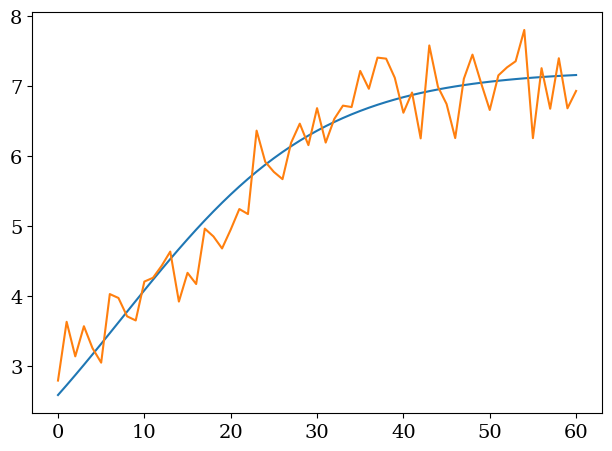

In [11]:
plt.plot(demand)
df = df_list[1]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
yield_ = np.nanpercentile(df_pivot, 50, axis=1)/10000
plt.plot(yield_)

## Production Function

In [12]:
df = df_list[2]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
F = np.nanpercentile(df_pivot, 50, axis=1)

df = df_list[3]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
P_ = np.nanpercentile(df_pivot, 50, axis=1)
P = np.concatenate((F[:29]/F[0]*1.7, P_))

df = df_list[5]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
M_ = np.nanpercentile(df_pivot, 50, axis=1)
M = np.concatenate((M_, 0.8 * np.arange(54, 61) + 20))/100

In [13]:
y_max = 10

N_req = 50
N_rel = 10 

Pr = 2
B = Pr

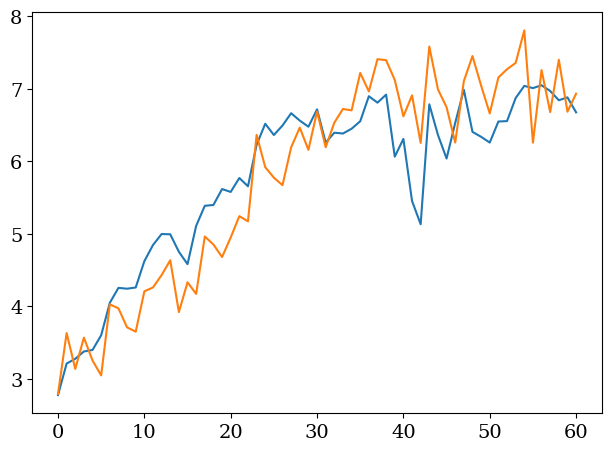

In [14]:
y = y_max * (1 - np.exp(-1/N_req * (N_rel + M * F))) * (1 - np.exp(-1/Pr * (B + M * P)))
plt.plot(y)
plt.plot(yield_)

# Comparison with simulation

In [45]:
ymax = 9  # Maximum achievable yield
Nr = 50  # Nutrient response parameter
p0 = 500  # Initial fixed operational cost
p1 = 1000  # Additional non operational cost
p_F = 0.8  # Price of fertilizer
Pr = 0.5
p_P = 10
N_rel = 10
economy_of_scale = 0.9

num_steps = 100  # Number of simulation time steps
size = 100  # Number of farmers

omega_plus = 0.2
omega_minus = 0.2
sigma = 0.3  # Exponent in households' utility function
beta = 5  # Land redistribution parameter
theta = 0.05 # Threshold wealth for farmer bankruptcy
delta = 0.1 # R&D investment fraction
demand_increase = 2.6  # Demand growth rate
demand_growth = 0.085
price_elasticity_demand = 0
competitiveness_param = 0.

investment_rate = 0.15

kappa = 0.90

In [46]:
def production(F_, M, P, land_per_farmer_, std = 0.01):
    prod_ = land_per_farmer_ * ymax * (1 - np.exp(-1/Nr * (N_rel + M * F_))) * (1 - np.exp(-1/Pr * (1.2 * Pr + P)))
    shape = np.concatenate((np.array(prod_.shape), [np.max(land_per_farmer_).astype(int)]), dtype=tuple)
    noise = np.random.normal(0, std, shape) 
    weight = np.arange(np.max(land_per_farmer_))[np.newaxis, : ] <= land_per_farmer_[:,None] -1
    nan_vector = np.ones(weight.shape) 
    nan_vector[np.invert(weight)] = np.nan
    prod_ = np.nanmean(prod_[:, np.newaxis] * (1 + noise) * nan_vector, axis=-1)
    return prod_
    
def derivative_F(F, M, P):
    return ymax * (1 - np.exp(-1/Pr *(1.2 * Pr + M * P))) * M/Nr * np.exp(-1/Nr * (N_rel + M * F)) * (1 + np.random.normal(0, 0.01, size = F.size))

def derivative_P(F, M, P):
    return ymax * (1 - np.exp(-1/Nr *(N_rel + M * F))) * 1/Pr * np.exp(-1/Pr *(1.2 * Pr + P)) * (1 + np.random.normal(0, 0.01, size = F.size))

def F_P_update(F, M, P, delta_y, costs, prod, nfarmers, alpha = 0.5):

    F_res = np.zeros(nfarmers)
    P_res = np.zeros(nfarmers) 

    Delta_F = derivative_F(F, M, P)
    Delta_P = derivative_P(F, M, P)

    delta_F = np.clip(p_P * Delta_F * delta_y / (p_P * Delta_F**2 + p_F * Delta_P**2), - alpha * F, alpha * F)
    delta_P = np.clip(p_F * Delta_P * delta_y / (p_P * Delta_F**2 + p_F * Delta_P**2), - alpha * P, alpha * P)

    mask = ((costs + delta_F * p_F + delta_P * p_P) / (prod + Delta_F * delta_F + Delta_P * P) < costs/prod) | (delta_y < 0)
    if np.any(mask):
        F_res[mask] = F[mask] + delta_F[mask]
        P_res[mask] = P[mask] + delta_P[mask]

    mask = np.invert(mask)
    if np.any(mask):
        F_res[mask] = F[mask] 
        P_res[mask] = P[mask] 

    return F_res, P_res
    

# Arrays to store values over the simulation
land_per_farmer = np.zeros((num_steps, size))
F = np.zeros((num_steps, size))
P = np.zeros((num_steps, size))
MP = np.zeros((num_steps, size))
inertia_rate = np.zeros((num_steps, size))
storage = np.zeros((num_steps, size))
expected_profit = np.zeros((num_steps, size))
expected_prod = np.zeros((num_steps, size))
prod = np.zeros((num_steps, size))
price = np.zeros((num_steps, size))
profit = np.zeros((num_steps, size))
revenues = np.zeros((num_steps, size))
costs = np.zeros((num_steps, size))
wealth = np.zeros((num_steps, size))
demand_per_farmer = np.zeros((num_steps, size))
fraction_sold = np.zeros((num_steps, size))
research_investment = np.zeros((num_steps, size))
quitting = np.zeros((num_steps, size))
active_farmer = np.zeros((num_steps, size), dtype=bool)
dev_F = np.zeros((num_steps, size))
dev_P = np.zeros((num_steps, size))
costs_per_unit = np.zeros((num_steps, size))
demand = np.zeros(num_steps)
markup = np.zeros((num_steps, size))
market_price = np.zeros(num_steps)
delta_p_M = np.zeros(num_steps)
average_price = np.zeros(num_steps)
delta_demand = np.zeros(num_steps)
new_delta_acquisition = np.zeros((num_steps, size))
delta_y = np.zeros((num_steps, size))
land_acquisition = np.zeros((num_steps, size))
demand_acquisition = np.zeros((num_steps, size))

df = df_list[1]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
yield_ = np.nanpercentile(df_pivot, 50, axis=1)[0]/10000
demand[0] = size * yield_

active_farmer[0] = True
land_per_farmer[0] = 1
F[0] = np.random.uniform(low = 30, high = 40, size = size)
P[0] = np.random.uniform(low = 1.5, high = 2, size = size)
prod[0] = np.random.uniform(low = 2, high=3, size=size)
prod[0] = prod[0]/np.sum(prod[0]) * demand[0]
MP[0] =  1/F[0] * (-Nr * np.log(1 - prod[0]/(ymax * (1 - np.exp(-1/Pr * (Pr + P[0]))))) - N_rel)

prod[0] = production(F[0], MP[0], P[0], land_per_farmer[0])
costs[0] = land_per_farmer[0] * (F[0] * p_F + P[0] * p_P + p0) + land_per_farmer[0]**economy_of_scale * p1
costs_per_unit[0] = costs[0]/prod[0]
# markup[0] = np.random.uniform(0.1, 0.5, size = size)#
markup[0] = 1.3 * np.average(costs_per_unit[0])/costs_per_unit[0] - 1
markup[0] = markup[0] * (1 + np.random.normal(0, 0.1, size = size))
price[0] = (1 + markup[0]) * costs_per_unit[0]
average_price[0] = np.average(price[0])
wealth[0] = 10000
research_investment[0] = 0
demand_per_farmer[0] = prod[0] + prod[0] * demand_growth * (1 - demand[0]/(demand_increase * demand[0]))#+ delta_demand[0] * distr
fraction_sold[0] = 1
profit[0] = markup[0] * costs[0]

for t in range(1, num_steps):
    print(t)
    active_farmer[t] = ~np.isnan(markup[t-1])
    markup[t, ~active_farmer[t]] = np.nan
    land_per_farmer[t, active_farmer[t]] = land_per_farmer[t-1, active_farmer[t]] + land_acquisition[t-1, active_farmer[t]]

    # Forcast and production phase
    delta_y = (demand_per_farmer[t-1, active_farmer[t]] - prod[t-1, active_farmer[t]])/land_per_farmer[t, active_farmer[t]]
    F[t, active_farmer[t]], P[t, active_farmer[t]] = F_P_update(F[t-1, active_farmer[t]], MP[t-1, active_farmer[t]], P[t-1, active_farmer[t]], delta_y, costs[t-1, active_farmer[t]], prod[t-1, active_farmer[t]], np.sum(active_farmer[t]))
    
    prod[t, active_farmer[t]] = production(F[t, active_farmer[t]], MP[t-1,active_farmer[t]], P[t, active_farmer[t]], land_per_farmer[t,active_farmer[t]]) 
    costs[t, active_farmer[t]] = land_per_farmer[t, active_farmer[t]] * (F[t, active_farmer[t]] * p_F + P[t,active_farmer[t]] * p_P + p0) + land_per_farmer[t, active_farmer[t]]**economy_of_scale *p1
    costs_per_unit[t, active_farmer[t]] = costs[t, active_farmer[t]] / prod[t, active_farmer[t]]
    q = 0.5

    markup[t, active_farmer[t]] = q * markup[t-1, active_farmer[t]] + (1 - q) * (average_price[t-1]/costs_per_unit[t-1, active_farmer[t]] - 1)
    price[t, active_farmer[t]] = (1 + markup[t, active_farmer[t]]) * costs_per_unit[t, active_farmer[t]]
    
    average_price[t] = np.percentile(price[t, active_farmer[t]], 45)

    demand_per_farmer[t, active_farmer[t]] = demand_per_farmer[t-1, active_farmer[t]] + demand_acquisition[t-1, active_farmer[t]]
    demand_per_farmer[t, active_farmer[t]] = demand_per_farmer[t, active_farmer[t]] + demand_per_farmer[t, active_farmer[t]] * demand_growth  * (1 - demand[t-1]/ (demand_increase * demand[0]))
    demand[t] = np.sum(demand_per_farmer[t, active_farmer[t]])
    fraction_sold[t, active_farmer[t]] = 1/prod[t, active_farmer[t]] * np.minimum(demand_per_farmer[t, active_farmer[t]], prod[t, active_farmer[t]])    

    # Compute profits and update wealth
    storage[t, active_farmer[t]]  = (1 - fraction_sold[t, active_farmer[t]]) * prod[t, active_farmer[t]]
    revenues[t, active_farmer[t]] = average_price[t] * fraction_sold[t, active_farmer[t]] * prod[t, active_farmer[t]]
    profit[t, active_farmer[t]] =  revenues[t, active_farmer[t]] - costs[t, active_farmer[t]]
    wealth[t, active_farmer[t]] = wealth[t-1, active_farmer[t]] + profit[t, active_farmer[t]]
    delta_p_M[t] = 0.6 * delta_p_M[t-1] + 0.4 * (market_price[t-1] - market_price[t])
    
    # Research and innovation investment
    research_investment[t, active_farmer[t]] = delta * profit[t, active_farmer[t]] 
    farms_innovating = np.random.rand(np.sum(active_farmer[t])) < 1 - np.exp(- 1/100 * research_investment[t, active_farmer[t]])
    advancement = 0.12 * np.random.rand(np.sum(active_farmer[t])) * farms_innovating
    MP[t, active_farmer[t]] = MP[t-1, active_farmer[t]] + advancement * MP[t-1, active_farmer[t]]  * (1 - MP[t-1, active_farmer[t]])
    wealth[t, active_farmer[t]] = wealth[t, active_farmer[t]] - delta * profit[t, active_farmer[t]]

    mask = markup[t] < theta
    if np.any(mask):
        prob = (markup[t] >= theta) * np.exp(beta * (wealth[t] * active_farmer[t]) / wealth[t, active_farmer[t]].max())
        prob /= np.sum(prob)
        auction_winner = np.random.choice(size, int(np.sum(land_per_farmer[t, mask])), p=prob, replace=True)
        indices, new_land = np.unique(auction_winner, return_counts=True)
        winners = np.zeros(size)
        winners[indices] = new_land
        land_acquisition[t,  winners > 0] = winners[winners > 0]
        demand_acquisition[t, winners > 0] = winners[winners > 0] * np.sum(demand_per_farmer[t, mask])/np.sum(winners)
        markup[t, mask] = np.nan
        
    markup[t, np.invert(active_farmer[t])] = np.nan
    print('------')

1
------
2
------
3
------
4
------
5
------
6
------
7
------
8
------
9
------
10
------
11
------
12
------
13
------
14
------
15
------
16
------
17
------
18
------
19
------
20
------
21
------
22
------
23
------
24
------
25
------
26
------
27
------
28
------
29
------
30
------
31
------
32
------
33
------
34
------
35
------
36
------
37
------
38
------
39
------
40
------
41
------
42
------
43
------
44
------
45
------
46
------
47
------
48
------
49
------
50
------
51
------
52
------
53
------
54
------
55
------
56
------
57
------
58
------
59
------
60
------
61
------
62
------
63
------
64
------
65
------
66
------
67
------
68
------
69
------
70
------
71
------
72
------
73
------
74
------
75
------
76
------
77
------
78
------
79
------
80
------
81
------
82
------
83
------
84
------
85
------
86
------
87
------
88
------
89
------
90
------
91
------
92
------
93
------
94
------
95
------
96
------
97
------
98
------
99
------


Text(0.5, 1.0, 'Land per Farmer')

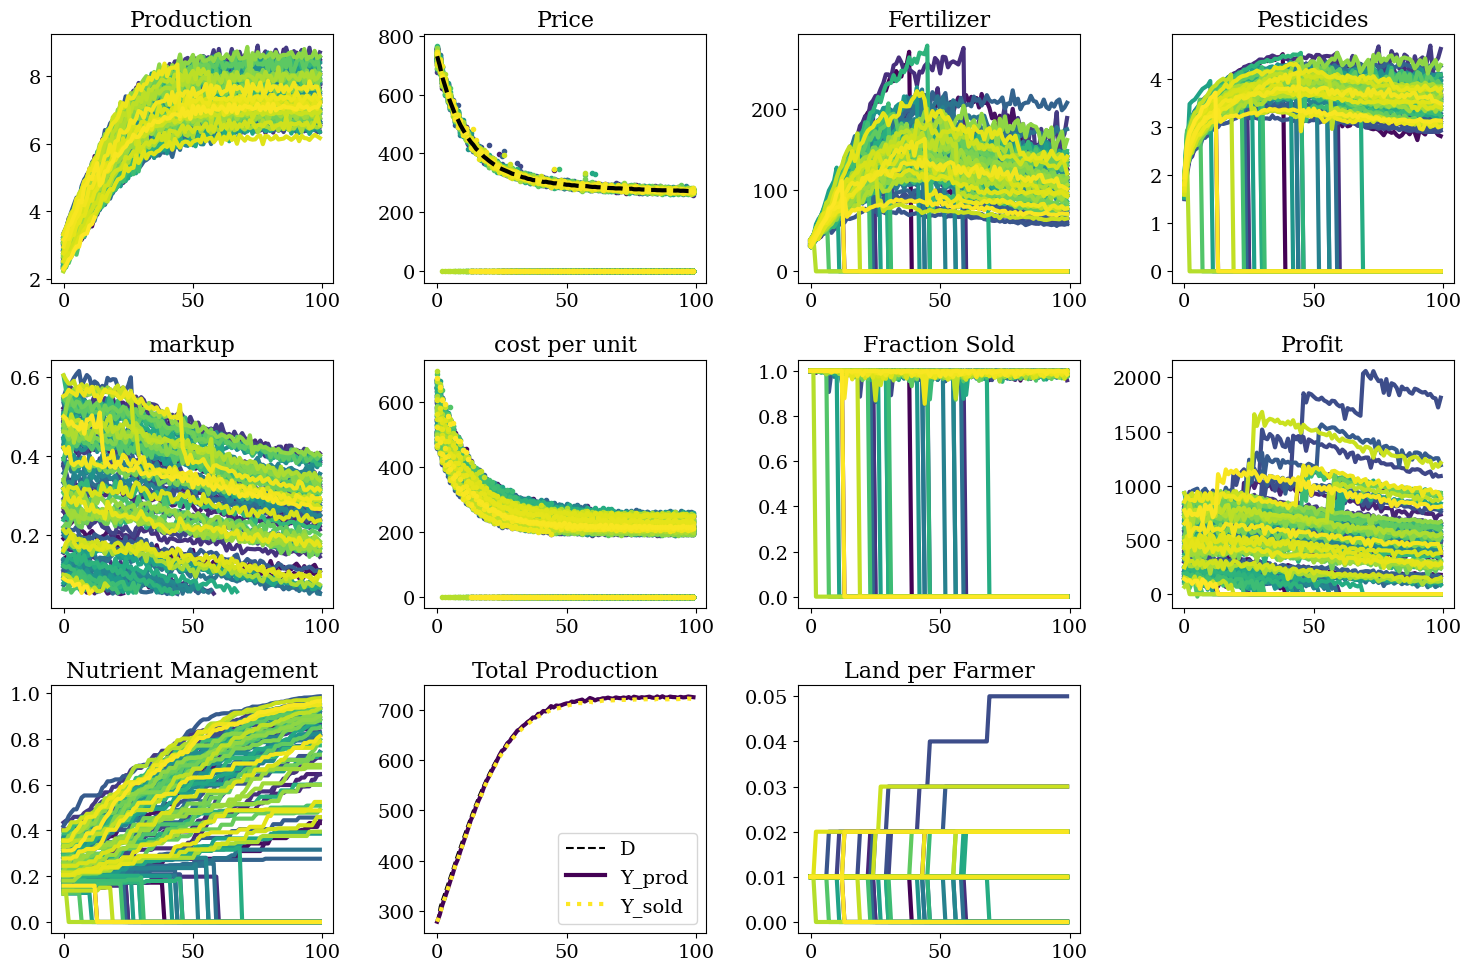

In [47]:

fig = plt.figure(figsize=(15,10))
gs = GridSpec(nrows=3, ncols=4)

c_matrix = generate_colormap_matrix('viridis', size)

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
for i in range(size):
    ax.plot(range(num_steps), prod[:, i]/land_per_farmer[:,i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Production')

# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
for i in range(size):
    ax.plot(range(num_steps), price[:, i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
ax.plot(range(num_steps), average_price, linestyle='--', color='k', lw = 3)
ax.set_title('Price')

# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
for i in range(size):
    ax.plot(range(num_steps), F[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[0, 3])
for i in range(size):
    ax.plot(range(num_steps), P[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Pesticides')

ax = fig.add_subplot(gs[1, 0])
for i in range(size):
    ax.plot(range(num_steps), markup[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('markup')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 2])
for i in range(size):
    ax.plot(range(num_steps), fraction_sold[:, i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Fraction Sold')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 3])
for i in range(size):
    ax.plot(range(num_steps), profit[:, i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Profit')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 1])
for i in range(size):
    ax.plot(range(num_steps), costs_per_unit[:, i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
ax.set_title('cost per unit')

ax = fig.add_subplot(gs[2, 0])
for i in range(size):
    ax.plot(range(num_steps), MP[:, i], linestyle='-', marker = '', c=c_matrix[i], lw = 3)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[2, 1])
ax.plot(range(num_steps), demand, linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(prod, axis=1), linestyle='-', c=c_matrix[0], lw = 3, label='Y_prod')
ax.plot(range(num_steps), np.sum(fraction_sold * prod, axis=1), linestyle=':', c=c_matrix[-1], lw = 3, label='Y_sold')
ax.set_title('Total Production')
ax.legend()


ax = fig.add_subplot(gs[2, 2])
for i in range(size):
    ax.plot(range(num_steps), land_per_farmer[:, i]/size, linestyle='-', marker = '', c=c_matrix[i], lw = 3)
ax.set_title('Land per Farmer')

Text(0.5, 1.0, 'Land per Farmer')

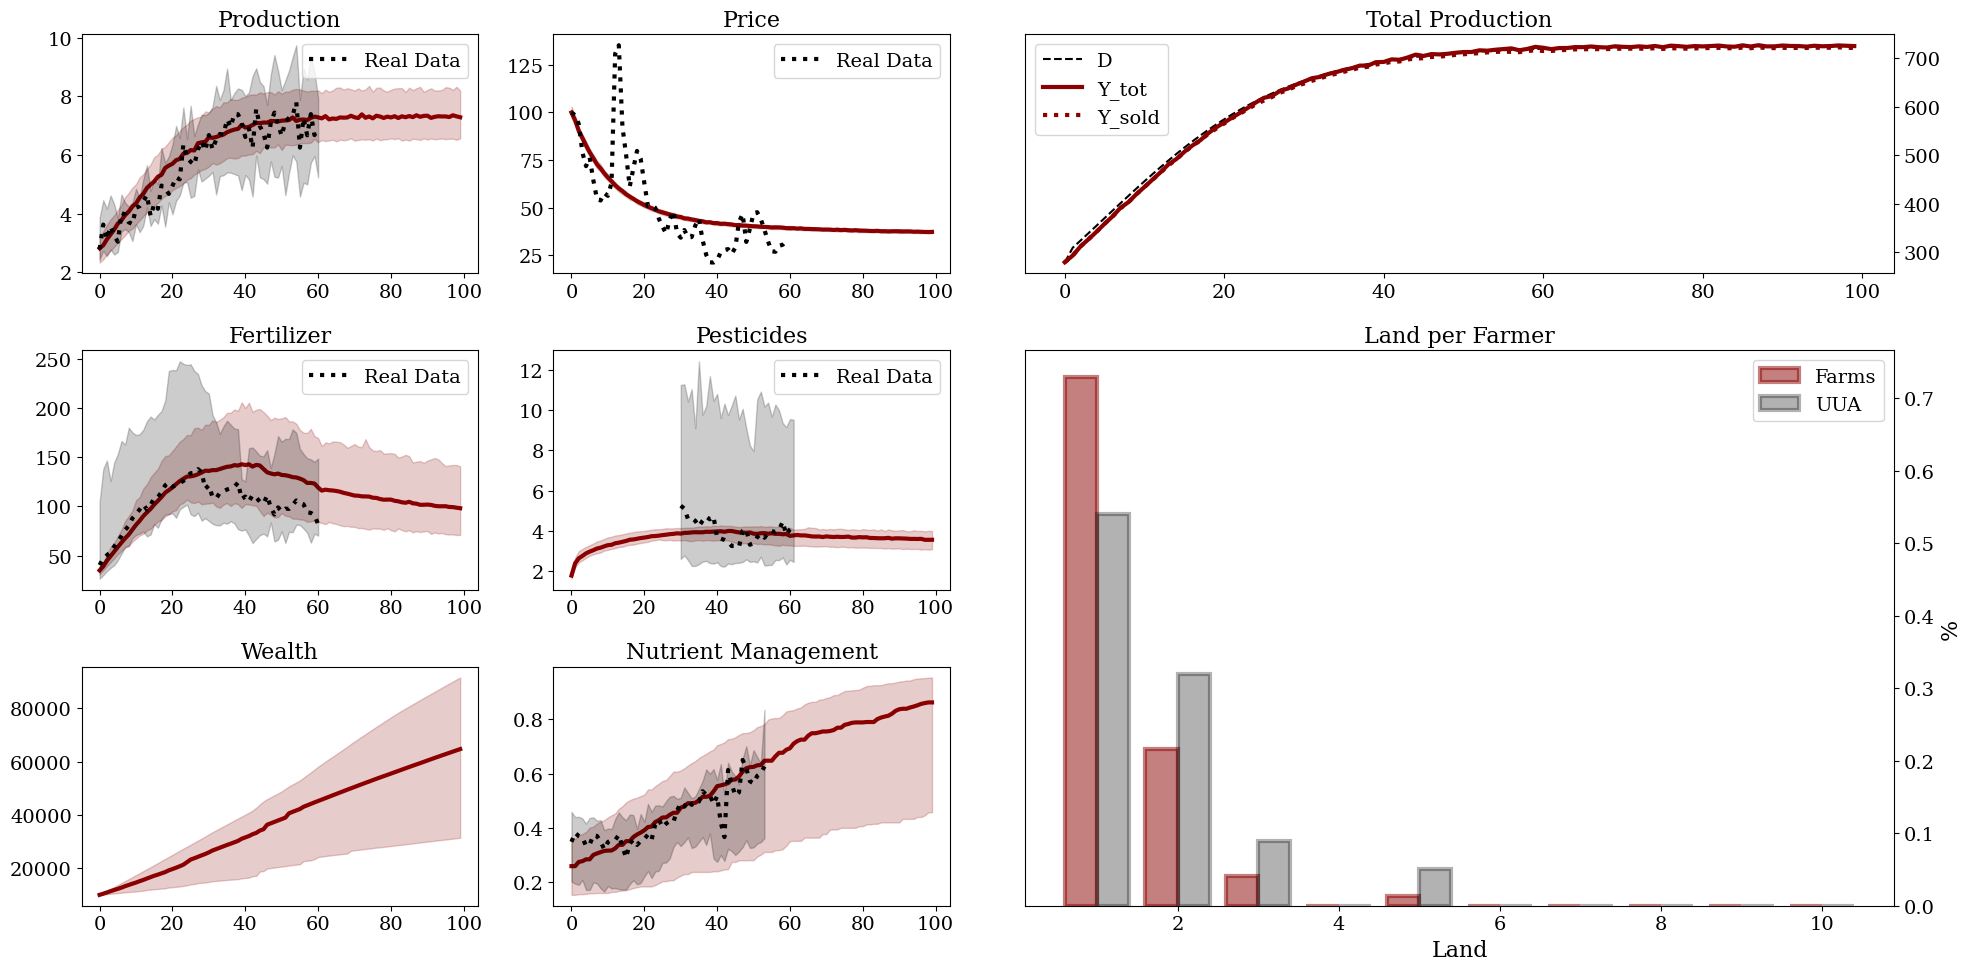

In [48]:
fig = plt.figure(figsize=(20,10))
gs = GridSpec(nrows=3, ncols=4)

c_matrix = generate_colormap_matrix('viridis', size)
color = 'darkred'

min_per = 10
max_per = 90

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
per_50 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, ls='-', lw = 3, zorder = 0.5)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 0.5)
df = df_list[1]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)/10000
per_5 = np.nanpercentile(df_pivot, 5, axis=1)/10000
per_95 = np.nanpercentile(df_pivot, 95, axis=1)/10000
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2)
ax.legend()
ax.set_title('Production')


# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
per_50 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50/per_50[0]*100, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5/per_50[0]*100, per_95/per_50[0]*100, color=color, alpha=0.2, zorder = 1)
# ax.plot(range(num_steps), average_price / average_price[0] * 100, linestyle='--', color=color, lw = 3, zorder = 2)
df = df_list[4]
ax.plot(range(df['Year'].size), df['Value']/df['Value'].iloc[0]*100, c = 'k', ls = ':', lw = 3, label='Real Data')
ax.legend()
ax.set_title('Price')


# Plotting fertilizer
ax = fig.add_subplot(gs[1, 0])
# per_50 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), max_per, axis=1)
# ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.plot(np.average(F, weights=prod, axis=1), color=color, lw = 3)
# ax.plot(np.where(active_farmer == True, F, np.nan), color=color, lw= 0.3, alpha = 0.3)
df = df_list[2]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)
per_5 = np.nanpercentile(df_pivot, 5, axis=1)
per_95 = np.nanpercentile(df_pivot, 95, axis=1)
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3, zorder = 2)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2, zorder = 2)
ax.legend()
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[1, 1])
per_50 = np.nanpercentile(np.where(active_farmer == True, P, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, P, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, P, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
df = df_list[3]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)
per_5 = np.nanpercentile(df_pivot, 5, axis=1)
per_95 = np.nanpercentile(df_pivot, 95, axis=1)
year = df_pivot.index.to_numpy()
ax.plot(np.arange(30, 30 + per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3, zorder = 2)
ax.fill_between(np.arange(30, 30 + per_50.size), per_5, per_95, color='k', alpha=0.2, zorder = 2)
ax.legend()
ax.set_title('Pesticides')

# Plotting profit and wealth
ax = fig.add_subplot(gs[2, 0])
per_50 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[2, 1])
per_50 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
df = df_list[5]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)
per_5 = np.nanpercentile(df_pivot, 5, axis=1)
per_95 = np.nanpercentile(df_pivot, 95, axis=1)
ax.plot(range(per_50.size), per_50/100, c='k', ls=':', label='Real Data', lw = 3)
ax.fill_between(range(per_50.size), per_5/100, per_95/100, color='k', alpha=0.2)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[0, 2:])
ax.plot(range(num_steps), demand, linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(prod, axis=1), linestyle='-', c=color, lw = 3, label = 'Y_tot')
ax.plot(range(num_steps), np.sum(fraction_sold * prod, axis=1), linestyle=':', c=color, lw = 3, label='Y_sold')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title('Total Production')
ax.legend()

ax = fig.add_subplot(gs[1:, 2:])
bins = np.arange(1, 12, 1)
x, farms_dimension = np.unique(land_per_farmer[-1, active_farmer[-1]], return_counts=True)
hist, bin_edges = np.histogram(land_per_farmer[-1, active_farmer[-1]], bins=bins)
ax.bar(bin_edges[:-1]-0.2, hist/np.sum(hist), width=0.4, facecolor='darkred', alpha=0.5, linewidth=3, edgecolor ='darkred', label = 'Farms')
ax.bar(bin_edges[:-1]+0.2, hist * bin_edges[:-1]/np.sum(land_per_farmer[-1, active_farmer[-1]]), width=0.4, facecolor='k', alpha=0.3, linewidth=3, edgecolor ='k', label = 'UUA')
ax.set_xlabel('Land')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel('%')
ax.legend()
ax.set_title('Land per Farmer')



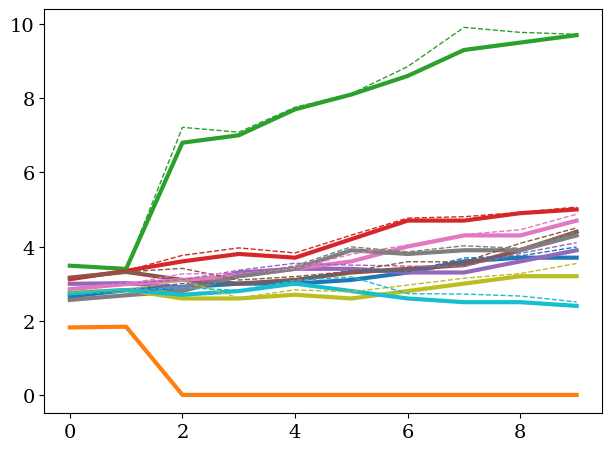

In [63]:
plt.plot(demand_per_farmer, lw = 3);
plt.plot(prod, ls = '--', lw = 1);